In [2]:
import pandas as pd 
import numpy as np
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
import re
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
df = pd.read_csv("C:/Users/hanna/Scape-Save-DAEN690/Datasets/indeed_cleaned.csv.gz") 
cos_df = pd.read_excel("C:/Users/hanna/Scape-Save-DAEN690/Datasets/careeronestop_data.xlsx")
usa_df = pd.read_excel("C:/Users/hanna/Scape-Save-DAEN690/Datasets/USAJobs_data.xlsx") 

### Data Cleaning

In [4]:
#Remove duplicate postings if the job title, description and location are the same 
df.drop_duplicates(subset=['job_title', 'description_text', 'location'], inplace=True)
cos_df.drop_duplicates(subset=['job_title', 'description', 'location'], inplace=True)
usa_df.drop_duplicates(subset=['job_title', 'description', 'location'], inplace=True)

In [5]:
def clean(text):
    #remove url
    output = re.sub(r'https://\S*','', text)

    #remove numerical values 
    output = ''.join(filter(lambda x: not x.isdigit(), output))

    #convert to lowercase 
    output = output.lower()

    #remove \r, \n
    rep = r'|'.join((r'\r',r'\n'))
    output = re.sub(rep,'',output)

    #remove duplicated punctuation
    output = re.sub(r'([!()\-{};:,<>./?@#$%\^&*_~]){2,}', lambda x: x.group()[0], output)
    
    #remove extra space
    output = re.sub(r'\s+', ' ', output).strip()
    
    #remove string if string only contains punctuation
    if sum([i.isalpha() for i in output])== 0:
        output = ''
        
    return output
    
df['description_text'] = df['description_text'].apply(clean)
#convert to unicode
cos_df['description'] = (cos_df['description'].values.astype("U"))
cos_df['description']= cos_df['description'].apply(clean)
usa_df['description'] = usa_df['description'].apply(clean)

In [6]:
#Set to lowercase so capitalized titles don't get counted separately
def lowercase(out): 
    out = out.lower()
    
    return out 

df['job_title'] = df['job_title'].apply(lowercase)
#convert to unicode 
cos_df['job_title'] = (cos_df['job_title'].values.astype("U"))
cos_df['job_title'] = cos_df['job_title'].apply(lowercase)
usa_df['job_title'] = usa_df['job_title'].apply(lowercase)

In [7]:
#Create function to categorize role types 

def role_type(x):
    if 'lead' in x:
        return 'senior'
    elif 'senior' in x:
        return 'senior'
    elif 'sr' in x:
        return 'senior'
    elif 'chief' in x:
        return 'upper mgmt'
    elif 'manager' in x:
        return 'upper mgmt'
    elif 'principal' in x:
        return 'upper mgmt'
    elif 'junior' in x:
        return 'entry-level'
    elif 'jr' in x:
        return 'entry-level'
    elif 'entry-level' in x:
        return 'entry-level'
    elif 'entry level' in x:
        return 'entry-level'
    elif 'professor' in x: 
        return 'academia'
    else:
        return 'other'
    
df['role_type'] = df['job_title'].apply(role_type)
cos_df['role_type'] = cos_df['job_title'].apply(role_type)
usa_df['role_type'] = usa_df['job_title'].apply(role_type)

#Can be used for visualizations 
df_in = df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]
df_cos = cos_df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]
df_usa = usa_df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]

### BERTopic Model

In [8]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic 
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

seed_topic_list = [["security", "cybersecurity", "information security", "technical", "forensic support"
                    "architect", "information", "penetration", "knowledge", "solution", "nist", "soc", "dod", "network", 
                     "risk management", "risk", "data", "cyber", "system", "privacy", "tester", "incident response", "vulnerability", "skill"
                     "network", "data", "policy", "procedure"]]

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings #10 or 30 
hdbscan_model = HDBSCAN(min_cluster_size=30, min_samples=5, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# Step 4 - Tokenize topics
# ngram_range set to 2 so the topics extracted can also be 'two-words' instead of one 
vectorizer_model = CountVectorizer(ngram_range=(1,3), stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - Fine-tune topic representations with 
# reduces redundacy and improve diversity of keywords using MMR 
representation_model = MaximalMarginalRelevance(0.5)

#CareerOneStop model 
topic_model = BERTopic(
  embedding_model=embedding_model, # Step 1: Embedding        
  umap_model=umap_model, # Step 2: Dimensionality reduction                   
  hdbscan_model=hdbscan_model, # Step 3: Clustering              
  vectorizer_model=vectorizer_model, # Step 4: Tokenizer         
  ctfidf_model=ctfidf_model, # Step 5: Weighting scheme                
  representation_model=representation_model, nr_topics=25, seed_topic_list=seed_topic_list) # Step 6: Fine-tune topic representation 

#Indeed model 
topic_model_in = BERTopic(
  embedding_model=embedding_model,          
  umap_model=umap_model,                    
  hdbscan_model=hdbscan_model,              
  vectorizer_model=vectorizer_model,       
  ctfidf_model=ctfidf_model,                
  representation_model=representation_model, 
  nr_topics=25, seed_topic_list=seed_topic_list) 

#USAjobs model 
topic_model_usa = BERTopic(
  embedding_model=embedding_model,          
  umap_model=umap_model,                    
  hdbscan_model=hdbscan_model,              
  vectorizer_model=vectorizer_model,       
  ctfidf_model=ctfidf_model,                
  representation_model=representation_model, 
  nr_topics=25, seed_topic_list=seed_topic_list)

In [9]:
#Indeed model
topic_in, prob_in = topic_model_in.fit_transform(df['description_text'].values.astype('U'))

In [10]:
#CareerOneStop model
topic, prob = topic_model.fit_transform(cos_df['description'].values.astype('U'))

In [11]:
#USAjobs model 
topic_usa, prob_usa = topic_model_usa.fit_transform(usa_df['description'].values.astype('U'))

In [12]:
topic_model_in.visualize_barchart()

In [13]:
topic_model.visualize_barchart()

In [14]:
topic_model_usa.visualize_barchart()

In [15]:
topic_model.visualize_heatmap()

In [16]:
topic_model_in.visualize_heatmap()

In [17]:
topic_model_usa.visualize_heatmap()

In [18]:
#merge topics with similarities > 0.85 

#CareerOneStop model 
topics_to_merge_cos = [[0,1],[8,0], [0,9], [0,13], [8,1]]
topic_model.merge_topics(cos_df['description'], topics_to_merge_cos)

#USAjobs model 
topics_to_merge_usa = [3,0]
topic_model_usa.merge_topics(usa_df['description'], topics_to_merge_usa)

In [19]:
#Updated careeronestop model with merged topics 
freq = topic_model.get_topic_info()
freq

,Topic,Count,Name
0,-1,2070,-1_experience_cybersecurity_risk_years
1,0,5333,0_information_experience_technical_cybersecurity
2,1,178,1_discovery_litigation_forensic_foia
3,2,143,2_xerox_security_response_end
4,3,131,3_icims_cloud security architect_concentrix_cl...
5,4,112,4_rubrik_minimum maximum_cloud_employment
6,5,106,5_compensation range_pwc_oracle_pricewaterhous...
7,6,100,6_guidehouse_required_grumman_northrop
8,7,97,7_trellix_tiaa_click applicants_benefits
9,8,66,8_heart_american heart association_infrastruct...


In [20]:
freq_in = topic_model_in.get_topic_info()
freq_in

,Topic,Count,Name
0,-1,4059,-1_experience_cybersecurity_management_technical
1,0,4191,0_experience_information_cybersecurity_risk
2,1,377,1_faculty_cybersecurity_teaching_information
3,2,238,2_usa remote_experience_aws_cloud security
4,3,183,3_experience_leidos_cybersecurity_navy federal
5,4,152,4_information security_vulnerability_risk mana...
6,5,108,5_paypal_information security_mandiant_costco
7,6,103,6_soc_security_process_automation
8,7,96,7_services_gecos_cybersecurity_requirements gdit
9,8,88,8_security_northrop grumman employees_dod_pion...


In [21]:
#Updated USAjobs model with merged topics 
freq_usa = topic_model_usa.get_topic_info()
freq_usa

,Topic,Count,Name
0,-1,14,-1_fema_dhs_emergency management_investigations
1,0,148,0_information_position_federal_requirements
2,1,58,1_security_program_federal_telework
3,2,46,2_network_systems_requirements_dod


In [22]:
#Evaluate the relevant terms and use the job titles to identify a pattern within the data 
topic_model.get_topic(freq.iloc[7]["Topic"])

[('guidehouse', 0.01830318670201723),
 ('required', 0.01698561488637402),
 ('grumman', 0.01437883918413036),
 ('northrop', 0.01437883918413036),
 ('employees', 0.010551671750009909),
 ('dod', 0.008525204991873774),
 ('clearance', 0.007992249808767896),
 ('certification', 0.006648673277778719),
 ('cyber', 0.0064751988158161),
 ('disability', 0.00616088687984186)]

In [23]:
cos_doc = topic_model.get_document_info(cos_df['description'])
in_doc = topic_model_in.get_document_info(df['description_text'])
usa_doc = topic_model_usa.get_document_info(usa_df['description'])

In [24]:
cos_doc.to_csv("C:/Users/hanna/OneDrive/Documents/DAEN 690/cos_doc.csv", encoding='utf-8')
in_doc.to_csv("C:/Users/hanna/OneDrive/Documents/DAEN 690/in_doc.csv", encoding='utf-8')
usa_doc.to_csv("C:/Users/hanna/OneDrive/Documents/DAEN 690/usa_doc.csv", encoding='utf-8')

In [25]:
#CareerOneStop model intertopic distance map
topic_model.visualize_topics()

In [26]:
#Indeed model intertopic distance map 
topic_model_in.visualize_topics()

#Unable to generate an intertopic distance map for USAjobs model as an error is generated due to having too few topics 

In [27]:
#save models for future references 
#topic_model.save("cos_model")
#topic_model_in.save("in_model")
#topic_model_usa.save("usa_model")

In [28]:
#load model 
#topic_usa = BERTopic.load("usa_model")
#topic = BERTopic.load("cos_model")
#topic_in = BERTopic.load("in_model")

### Topic Mapping 

In [29]:
#Add the topic for each record in the dataframe - CareerOneStop & Indeed Data
cos_df['topic'] = topic
df['topic_in'] = topic_in
usa_df['topic_usa'] = topic_usa


CareerOneStop Dataset Topic Mapping 

In [30]:
#Group all keywords with a certain topic - CareerOneStop
topic_0 = cos_df[cos_df['topic'] == 0].groupby('keyword')['keyword'].count().sort_values(ascending=True).to_frame()
topic_1 = cos_df[cos_df['topic'] == 1].groupby('keyword')['keyword'].count().sort_values(ascending=True).to_frame()
topic_2 = cos_df[cos_df['topic'] == 2].groupby('keyword')['keyword'].count().sort_values(ascending=True).to_frame()
topic_3 = cos_df[cos_df['topic'] == 3].groupby('keyword')['keyword'].count().sort_values(ascending=True).to_frame()
topic_4 = cos_df[cos_df['topic'] == 4].groupby('keyword')['keyword'].count().sort_values(ascending=True).to_frame()
topic_7 = cos_df[cos_df['topic'] == 7].groupby('keyword')['keyword'].count().sort_values(ascending=True).to_frame()

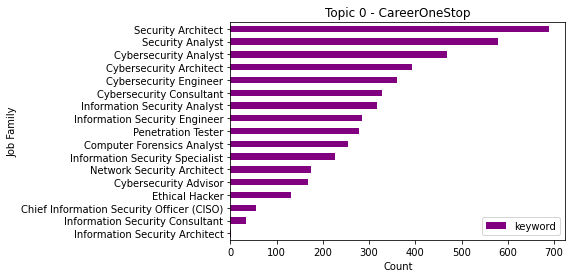

In [31]:
#Visualization for Topic0
ax = topic_0.plot.barh(color='purple')

# set the title and axis labels
ax.set_title('Topic 0 - CareerOneStop')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# show the plot
plt.show()

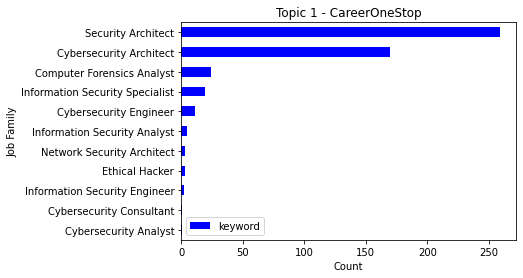

In [32]:
#Topic1 visualization
ax = topic_1.plot.barh(color='blue')

# set the title and axis labels
ax.set_title('Topic 1 - CareerOneStop')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# show the plot
plt.show()

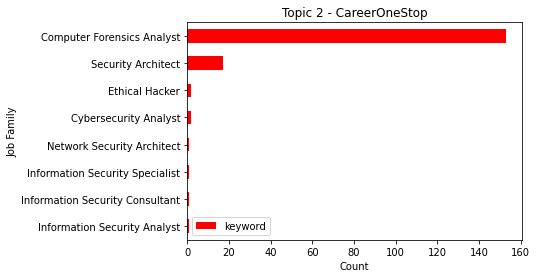

In [33]:
#Topic 2 visualization
ax = topic_2.plot.barh(color='red')

# set the title and axis labels
ax.set_title('Topic 2 - CareerOneStop')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# show the plot
plt.show()

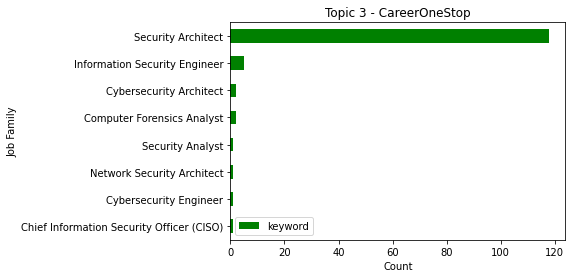

In [34]:
#Topic 3 visualization
ax = topic_3.plot.barh(color='green')

# set the title and axis labels
ax.set_title('Topic 3 - CareerOneStop')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# show the plot
plt.show()

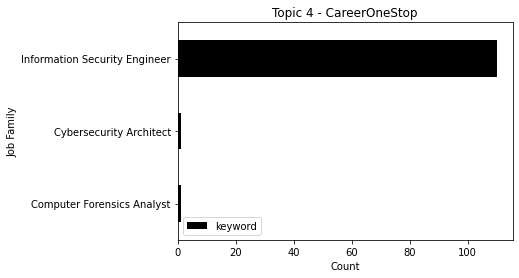

In [35]:
#Topic 4 visualization
ax = topic_4.plot.barh(color='black')

# set the title and axis labels
ax.set_title('Topic 4 - CareerOneStop')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# show the plot
plt.show()

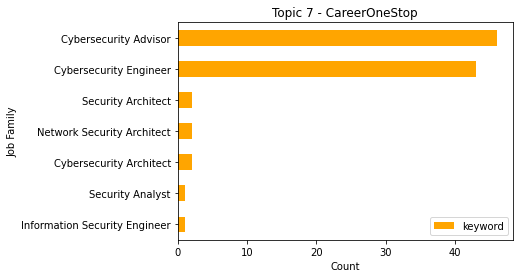

In [36]:
#Topic 7 visualization
ax = topic_7.plot.barh(color='orange')

# set the title and axis labels
ax.set_title('Topic 7 - CareerOneStop')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# show the plot
plt.show()

Indeed Dataset Topic Mapping

In [37]:
indeed_titles = df['job_title'].value_counts()
# len(indeed_titles) #5350. There are 5350 unique job titles in the indeed dataset
indeed_titles = df['job_title'].value_counts().sort_values(ascending = False).to_frame()

#choose the top 10 job titles from the dataset(indeed)
indeed_titles = indeed_titles[0:10]
indeed_titles

,job_title
cyber security engineer,168
information security analyst,150
security engineer,120
cybersecurity engineer,100
cyber security analyst,99
cloud security architect,95
network engineer,92
cybersecurity analyst,87
senior security engineer,79
information security engineer,71


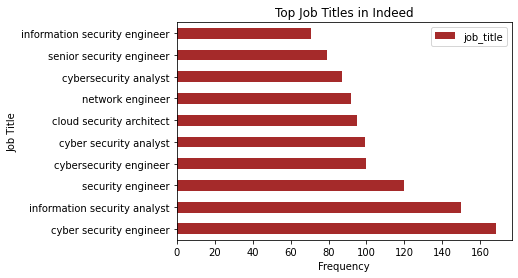

In [38]:
#Visualize the top job titles in indeed data
ax = indeed_titles.plot.barh(color='brown')

# set the title and axis labels
ax.set_title('Top Job Titles in Indeed')
ax.set_xlabel('Frequency')
ax.set_ylabel('Job Title')

# show the plot
plt.show()

In [39]:
#Create a data frame containing job_title and the corresponding topic for Indeed
indeed_topic_df = df[['job_title', 'topic_in']]
indeed_topic_df

,job_title,topic_in
0,senior cyber security account executive (remot...,0
1,cyber defense analyst iii,0
2,senior cybersecurity incident response analyst,9
3,managing principal - cybersecurity,-1
4,cybersecurity systems analyst,-1
...,...,...
10731,director of it management (ciso),9
10733,"program manager, compliance, google cloud ciso",0
10734,head of program management - office of the ciso,-1
10735,"lead technical program manager, compliance ena...",0


In [40]:
#Filter only the top job titles
indeed_list = indeed_titles.index.to_list()
indeed_topic_df = indeed_topic_df[indeed_topic_df['job_title'].isin(indeed_list)]
indeed_topic_df

,job_title,topic_in
14,cyber security analyst,-1
21,cyber security engineer,0
24,cybersecurity engineer,0
48,cybersecurity analyst,0
74,cybersecurity engineer,-1
...,...,...
10690,cloud security architect,2
10708,cloud security architect,2
10717,cloud security architect,2
10722,cloud security architect,2


In [41]:
#Group all keywords with a certain topic - Indeed 
topic_in_0 = indeed_topic_df[indeed_topic_df['topic_in'] == 0].groupby('job_title')['job_title'].count().sort_values(ascending=True).to_frame()
topic_in_1 = indeed_topic_df[indeed_topic_df['topic_in'] == 1].groupby('job_title')['job_title'].count().sort_values(ascending=True).to_frame()
topic_in_2 = indeed_topic_df[indeed_topic_df['topic_in'] == 2].groupby('job_title')['job_title'].count().sort_values(ascending=True).to_frame()
topic_in_3 = indeed_topic_df[indeed_topic_df['topic_in'] == 3].groupby('job_title')['job_title'].count().sort_values(ascending=True).to_frame()
topic_in_4 = indeed_topic_df[indeed_topic_df['topic_in'] == 4].groupby('job_title')['job_title'].count().sort_values(ascending=True).to_frame()

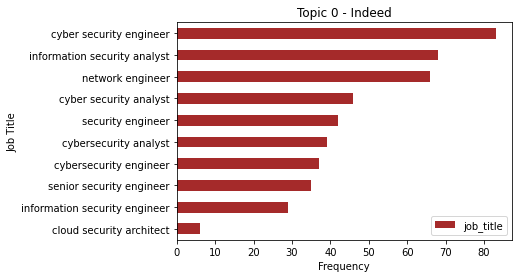

In [42]:
#Topic 0 - Indeed 
ax = topic_in_0.plot.barh(color='brown')

# set the title and axis labels
ax.set_title('Topic 0 - Indeed')
ax.set_xlabel('Frequency')
ax.set_ylabel('Job Title')

# show the plot
plt.show()

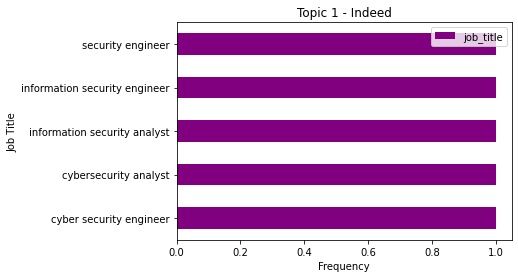

In [43]:
#Topic 1 - Indeed
ax = topic_in_1.plot.barh(color='purple')

# set the title and axis labels
ax.set_title('Topic 1 - Indeed')
ax.set_xlabel('Frequency')
ax.set_ylabel('Job Title')

# show the plot
plt.show()

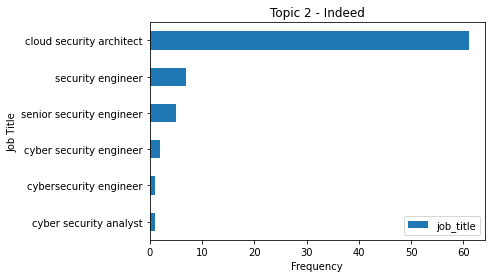

In [44]:
#Topic 2 - Indeed
ax = topic_in_2.plot.barh()

# set the title and axis labels
ax.set_title('Topic 2 - Indeed')
ax.set_xlabel('Frequency')
ax.set_ylabel('Job Title')

# show the plot
plt.show()

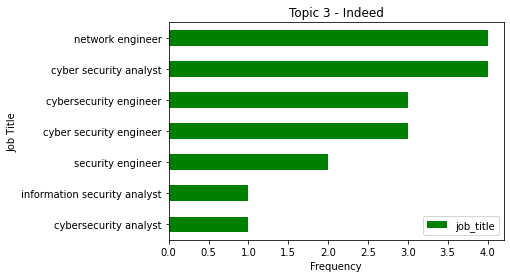

In [45]:
#Topic 3 - Indeed
ax = topic_in_3.plot.barh(color='green')

# set the title and axis labels
ax.set_title('Topic 3 - Indeed')
ax.set_xlabel('Frequency')
ax.set_ylabel('Job Title')

# show the plot
plt.show()

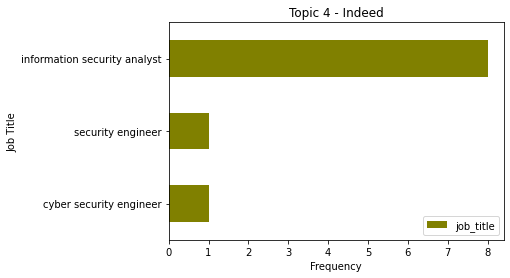

In [46]:
#Topic 4 - Indeed
ax = topic_in_4.plot.barh(color='olive')

# set the title and axis labels
ax.set_title('Topic 4 - Indeed')
ax.set_xlabel('Frequency')
ax.set_ylabel('Job Title')

# show the plot
plt.show()

USAjobs Dataset Topic Mapping 

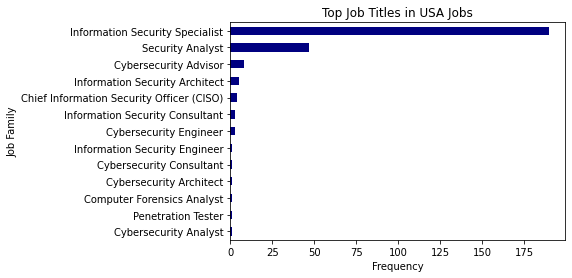

In [47]:
usa_job_titles = usa_df['keyword'].value_counts().sort_values(ascending=True)

#Visualize the top job titles in USA Jobs data
ax = usa_job_titles.plot.barh(color='navy')

# set the title and axis labels
ax.set_title('Top Job Titles in USA Jobs')
ax.set_xlabel('Frequency')
ax.set_ylabel('Job Family')

# show the plot
plt.show()

In [48]:
#Group all keywords with a certain topic - USA Jobs
#USA Jobs only has 2 topics; topic 0 & 1
topic_usa_0 = usa_df[usa_df['topic_usa'] == 0].groupby('keyword')['keyword'].count().sort_values(ascending=True).to_frame()
topic_usa_1 = usa_df[usa_df['topic_usa'] == 1].groupby('keyword')['keyword'].count().sort_values(ascending=True).to_frame()
# topic_usa_2 = usa_df[usa_df['topic_usa'] == 2].groupby('keyword')['keyword'].count().sort_values(ascending=True).to_frame()
# topic_usa_3 = usa_df[usa_df['topic_usa'] == 3].groupby('keyword')['keyword'].count().sort_values(ascending=True).to_frame()
# topic_usa_4 = usa_df[usa_df['topic_usa'] == 4].groupby('keyword')['keyword'].count().sort_values(ascending=True).to_frame()

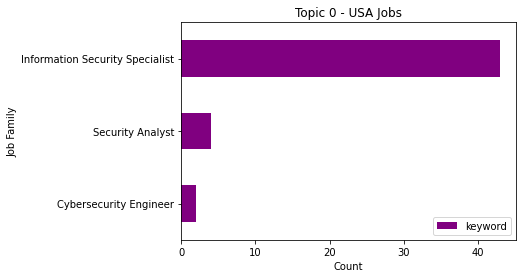

In [49]:
#Visualization for Topic0 - USA Jobs
ax = topic_usa_0.plot.barh(color='purple')

# set the title and axis labels
ax.set_title('Topic 0 - USA Jobs')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# show the plot
plt.show()

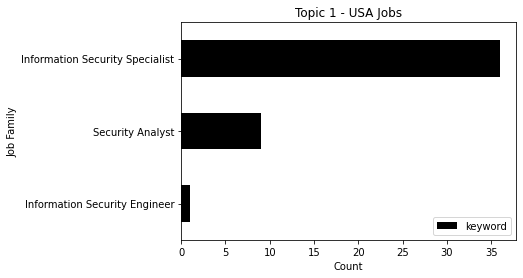

In [50]:
#Visualization for Topic 1 - USA Jobs
ax = topic_usa_1.plot.barh(color='black')

# set the title and axis labels
ax.set_title('Topic 1 - USA Jobs')
ax.set_xlabel('Count')
ax.set_ylabel('Job Family')

# show the plot
plt.show()